<a href="https://colab.research.google.com/github/bclee232/DLwP/blob/master/4_boston.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape, test_data.shape)
# 404 training and 102 test
# 13 features

(404, 13) (102, 13)


In [2]:
# feature-wise normalisation (features have different scale)
mean = train_data.mean(axis=0) # axis=0 for each feature
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [9]:
# build the network
from keras.models import Sequential
from keras.layers import Dense

def build_model():
  model = Sequential()
  model.add(Dense(64, activation='relu', 
                  input_shape=(train_data.shape[1],))) # 13 for shape
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1)) # 1 output of median price
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [20]:
# K fold validation
import numpy as np

k = 4
n_samples = len(train_data) // k
n_epochs = 50 # should be 500 for determining optimal epoch
list_scores = []
list_mae_hist = []

for i in range(k):
  print('processing fold:', i)
  # prepares a partition for validation data
  x_val = train_data[i * n_samples: (i+1) * n_samples]
  y_val = train_targets[i * n_samples: (i+1) * n_samples]

  # prepares other partitions, where each is training data
  # concatenate data before and after validation partition
  part_x_train = np.concatenate(
      [train_data[:i * n_samples], train_data[(i+1) * n_samples:]], axis=0
  )
  part_y_train = np.concatenate(
      [train_targets[:i * n_samples], train_targets[(i+1) * n_samples:]], axis=0
  )

  model = build_model()
  hist = model.fit(part_x_train, part_y_train, batch_size=1, 
                   epochs=n_epochs, validation_data=(x_val, y_val),
                   verbose=0) # verbose is silent mode
  mae_hist = hist.history['val_mae']
  list_mae_hist.append(mae_hist)
  # val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
  # list_scores.append(val_mae)

# print('avg', np.mean(list_scores))
avg_mae_hist = [np.mean([x[i] for x in list_mae_hist]) for i in range(n_epochs)]

processing fold: 0
processing fold: 1
processing fold: 2
processing fold: 3


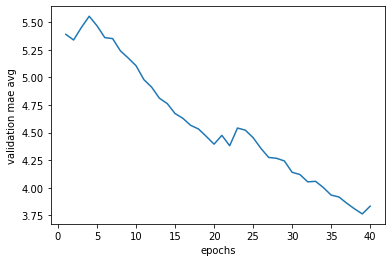

In [22]:
import matplotlib.pyplot as plt

# smooths the curve for better reading
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_hist = smooth_curve(avg_mae_hist[10:])

epochs = range(1, len(smooth_mae_hist) + 1)
plt.plot(epochs, smooth_mae_hist)
plt.xlabel('epochs')
plt.ylabel('validation mae avg')
plt.show() # 500 would show that 80 is optimal

In [28]:
new = build_model()
new.fit(train_data, train_targets, batch_size=16, epochs=80, verbose=0)
test_mse, test_mae = new.evaluate(test_data, test_targets)
print(test_mae) # off by $4500, book provides $2500

102/102 [==============================] - 0s 178us/step
4.541990280151367
